In [100]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os

In [101]:
# Sentiment data acquired by sentiment_analysis.py

sentiment_df = pd.read_csv('bulk_sentiment.csv')
sentiment_df.head()

,Ticker,Date,Headline,Sentiment Score
0,AAPL,2022-08-05,Why Apple Could Be At All-Time Highs By Year E...,0.0000
1,AAPL,2022-08-19,These Are the 16 Stocks Warren Buffett Has Bou...,-0.4404
2,AAPL,2023-08-24,Is Apple Inc (AAPL) Fairly Valued? An In-depth...,0.4404
3,AAPL,2024-01-08,Why I Sold Some Apple Stock to End 2023 and Wh...,0.0000
4,AAPL,2024-04-22,Apple Named a Top Pick for 2024 at BofA Ahead ...,0.2023


In [102]:
# Aggregate monthly sentiment scores
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df = sentiment_df.set_index(['Date', 'Ticker'])

aggregate_df = sentiment_df.reset_index('Ticker').groupby([pd.Grouper(freq='M'), 'Ticker'])[['Sentiment Score']].mean()

aggregate_df

C:\Users\gutob\AppData\Local\Temp\ipykernel_33348\62713767.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregate_df = sentiment_df.reset_index('Ticker').groupby([pd.Grouper(freq='M'), 'Ticker'])[['Sentiment Score']].mean()


Sentiment Score
Date       Ticker                 
2022-07-31 AAPL           0.260964
           ABBV           0.032167
           ABNB           0.153100
           ABT            0.023100
           ACN            0.215460
...                            ...
2025-07-31 VZ             0.329561
           WFC            0.228376
           WMT            0.135354
           XOM            0.126865
           ZM             0.124290

[3674 rows x 1 columns]

In [103]:
# Create rank for each day by sentiment score
aggregate_df['Rank'] = aggregate_df.groupby(level=0)['Sentiment Score'].transform(lambda x: x.rank(ascending=False))

aggregate_df

Sentiment Score  Rank
Date       Ticker                       
2022-07-31 AAPL           0.260964  10.0
           ABBV           0.032167  57.0
           ABNB           0.153100  30.0
           ABT            0.023100  59.0
           ACN            0.215460  20.0
...                            ...   ...
2025-07-31 VZ             0.329561   2.0
           WFC            0.228376  19.0
           WMT            0.135354  52.0
           XOM            0.126865  55.0
           ZM             0.124290  57.0

[3674 rows x 2 columns]

In [104]:
# Select top 5 stocks by sentiment for each month

filtered_df = aggregate_df[aggregate_df['Rank'] < 6].copy()
filtered_df.head(20)

Sentiment Score  Rank
Date       Ticker                       
2022-07-31 ADM            0.313400   5.0
           GOOGL          0.319300   3.0
           LCID           0.318450   4.0
           ORCL           0.413550   2.0
           PGR            0.757900   1.0
2022-08-31 ACN            0.371962   2.0
           AMZN           0.273539   5.0
           CL             0.348200   4.0
           FCX            0.440400   1.0
           SCHW           0.361200   3.0
2022-09-30 BAC            0.329300   3.0
           GILD           0.318450   4.0
           MRK            0.509350   1.0
           PDD            0.307286   5.0
           TXN            0.401900   2.0
2022-10-31 AXP            0.324300   5.0
           DHR            0.636900   1.0
           KO             0.385200   2.0
           TMO            0.379300   3.0
           WFC            0.340480   4.0

In [105]:
# Add 1 day to each date to signify the beginning of each month

filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['Date', 'Ticker'])

filtered_df.head(20)

Sentiment Score  Rank
Date       Ticker                       
2022-08-01 ADM            0.313400   5.0
           GOOGL          0.319300   3.0
           LCID           0.318450   4.0
           ORCL           0.413550   2.0
           PGR            0.757900   1.0
2022-09-01 ACN            0.371962   2.0
           AMZN           0.273539   5.0
           CL             0.348200   4.0
           FCX            0.440400   1.0
           SCHW           0.361200   3.0
2022-10-01 BAC            0.329300   3.0
           GILD           0.318450   4.0
           MRK            0.509350   1.0
           PDD            0.307286   5.0
           TXN            0.401900   2.0
2022-11-01 AXP            0.324300   5.0
           DHR            0.636900   1.0
           KO             0.385200   2.0
           TMO            0.379300   3.0
           WFC            0.340480   4.0

In [106]:
# Extract stocks to form porfolios for each month

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2022-08-01': ['ADM', 'GOOGL', 'LCID', 'ORCL', 'PGR'],
 '2022-09-01': ['ACN', 'AMZN', 'CL', 'FCX', 'SCHW'],
 '2022-10-01': ['BAC', 'GILD', 'MRK', 'PDD', 'TXN'],
 '2022-11-01': ['AXP', 'DHR', 'KO', 'TMO', 'WFC'],
 '2022-12-01': ['AXP', 'ISRG', 'SPG', 'TXN', 'UNH'],
 '2023-01-01': ['ACN', 'FCX', 'GILD', 'GOOGL', 'TMO'],
 '2023-02-01': ['ACN', 'ISRG', 'LLY', 'ORCL', 'TJX'],
 '2023-03-01': ['ACN', 'AVGO', 'BLK', 'SCHW', 'TXN'],
 '2023-04-01': ['ABT', 'DHR', 'KMB', 'LMT', 'REGN'],
 '2023-05-01': ['DHR', 'GILD', 'MDLZ', 'QCOM', 'SPG'],
 '2023-06-01': ['ACN', 'AMZN', 'FCX', 'GILD', 'PLD'],
 '2023-07-01': ['ACN', 'AMZN', 'CRM', 'KHC', 'PGR'],
 '2023-08-01': ['INTU', 'KHC', 'MDLZ', 'PDD', 'PLD'],
 '2023-09-01': ['ABBV', 'ABT', 'DHR', 'KHC', 'PGR'],
 '2023-10-01': ['CL', 'PGR', 'REGN', 'UNP', 'WFC'],
 '2023-11-01': ['ABT', 'AVGO', 'GIS', 'INTU', 'MDLZ'],
 '2023-12-01': ['ABT', 'AMZN', 'FCX', 'KMB', 'UNP'],
 '2024-01-01': ['INTU', 'KMB', 'TGT', 'TJX', 'UNH'],
 '2024-02-01': ['BLK', 'CRM', 'RTX',

In [107]:
# Download fresh stock prices for selected stocks

stocks_list = sentiment_df.index.get_level_values('Ticker').unique().tolist()

prices_df = yf.download(tickers=stocks_list, start='2022-01-01', end='2025-09-01', auto_adjust=False)

prices_df.head(100)

[*********************100%***********************]  100 of 100 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2022-01-03  178.645630  118.637070  172.679993  130.151352  385.631042   
2022-01-04  176.378342  118.409302  170.800003  127.090408  382.875214   
2022-01-05  171.686707  119.031303  162.250000  126.519417  376.132538   
2022-01-06  168.820694  118.470627  159.750000  126.500694  357.968964   
2022-01-07  168.987549  118.164017  166.050003  126.893814  351.103088   
...                ...         ...         ...         ...         ...   
2022-05-19  135.181244  135.437622  114.169998  106.044083  260.556091   
2022-05-20  135.417450  134.803818  112.550003  106.798569  263.451080   
2022-05-23  140.850311  132.143616  113.279999  108.486755  269.869537   
2022-05-24  138.143753  133.107712  106.239998  107.298431  265.984131   
2022-05-25  138.301208  135.651886  110.400002  106.751427  266.298401   

Price                                                                  ...  \
Ticker            ADBE        ADM         AMD        AMGN         AMT  ...   
Date                                                                   ...   
2022-01-03  564.369995  61.522823  150.240005  202.714844  256.866058  ...   
2022-01-04  554.000000  62.664646  144.419998  203.743210  253.628082  ...   
2022-01-05  514.429993  62.175308  136.149994  201.328781  237.303787  ...   
2022-01-06  514.119995  62.728088  136.229996  201.355621  237.590790  ...   
2022-01-07  510.700012  63.262749  132.000000  203.251389  239.106598  ...   
...                ...        ...         ...         ...         ...  ...   
2022-05-19  394.380005  76.750839   96.669998  222.533096  210.329880  ...   
2022-05-20  399.089996  76.878983   93.500000  225.015106  220.275986  ...   
2022-05-23  406.760010  79.231094   95.070000  226.415176  224.910919  ...   
2022-05-24  398.410004  80.320213   91.160004  229.006271  233.116699  ...   
2022-05-25  402.500000  81.244591   92.650002  230.024506  234.712784  ...   

Price         Volume                                                           \
Ticker          UBER      UNH      UNP      UPS         V        VZ       WFC   
Date                                                                            
2022-01-03  26089000  3033600  2450200  2319600   7694500  18240100  38978100   
2022-01-04  30845300  3908100  2647500  2741200  10629300  26376800  43855100   
2022-01-05  28498700  3921100  3651300  2710800   9594600  28697300  35072600   
2022-01-06  32434300  6555200  2342300  2102200   7877500  21563800  29720800   
2022-01-07  24875800  5494200  2346800  3014000  10702100  26512500  35149300   
...              ...      ...      ...      ...       ...       ...       ...   
2022-05-19  36461200  3813800  5428100  4382900   9012400  23186400  25211900   
2022-05-20  32104700  3068200  3796000  3483300   6966600  24181800  35410400   
2022-05-23  35204800  2279800  3079300  2837700  12187400  16761800  27979100   
2022-05-24  40726100  2658100  2159700  2865100   7458500  25414700  23996000   
2022-05-25  31270800  3161600  2006700  3370100   5457200  19831500  22343900   

Price                                     
Ticker           WMT       XOM        ZM  
Date                                      
2022-01-03  20706600  24282400   3171900  
2022-01-04  33930000  38584000   5269800  
2022-01-05  35418000  34033300   3772300  
2022-01-06  21828900  30668500   4002500  
2022-01-07  19723500  23985400   3089400  
...              ...       ...       ...  
2022-05-19  71008500  24387400   4746900  
2022-05-20  49356000  28795000   4741400  
2022-05-23  43680900  27239300  11240300  
2022-05-24  34584900  24293300  27414900  
2022-05-25  27121800  29947800  13892000  

[100 rows x 600 columns]

In [108]:
# Calculate portfolio returns with monthly rebalancing

returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2022-08-01,-0.000097
2022-08-02,0.006541
2022-08-03,0.017385
2022-08-04,-0.017257
2022-08-05,-0.002575
...,...
2025-07-03,0.001771
2025-07-07,-0.012709
2025-07-08,-0.002140


In [109]:
# Download prices and calculate returns, comparing to NASDAQ return

qqq_df = yf.download(tickers='QQQ', start='2022-01-01', end='2025-09-01', auto_adjust=False)

qqq_return = np.log(qqq_df['Adj Close']).diff().dropna()

portfolio_df = portfolio_df.merge(qqq_return, left_index=True, right_index=True)

portfolio_df = portfolio_df.rename(columns={'QQQ': 'NASDAQ Return'})
portfolio_df = portfolio_df.rename(columns={'portfolio_return': 'Portfolio Return'})

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Portfolio Return,NASDAQ Return
Date,,
2022-08-01,-0.000097,-0.000602
2022-08-02,0.006541,-0.002986
2022-08-03,0.017385,0.026868
2022-08-04,-0.017257,0.004666
2022-08-05,-0.002575,-0.008202
...,...,...
2025-07-03,0.001771,0.009792
2025-07-07,-0.012709,-0.007561
2025-07-08,-0.002140,0.000561


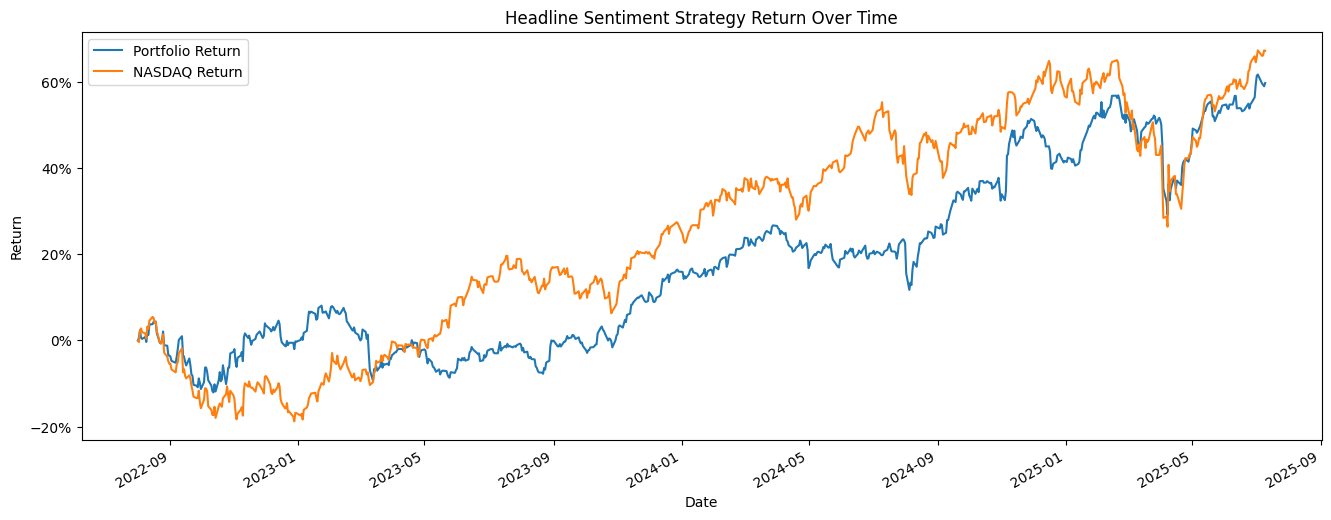

In [110]:
# Building cumulative returns and comparing

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Headline Sentiment Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [111]:
# Statistical analysis on NASDAQ vs. Portfolio returns

daily_returns_df = portfolio_df.copy()

correlation_matrix = daily_returns_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                  Portfolio Return  NASDAQ Return
Portfolio Return          1.000000       0.672517
NASDAQ Return             0.672517       1.000000


In [112]:
# Sharpe Ratio (Risk-adjusted return)

portfolio_daily_returns = daily_returns_df['Portfolio Return']
nasdaq_daily_returns = daily_returns_df['NASDAQ Return']

def calculate_sharpe_ratio(returns_series):
    # Assuming a risk-free rate of 0 for simplicity
    # 252 is the standard number of trading days in a year
    daily_sharpe = returns_series.mean() / returns_series.std()
    return daily_sharpe * (252**0.5)

portfolio_sharpe = calculate_sharpe_ratio(portfolio_daily_returns)
nasdaq_sharpe = calculate_sharpe_ratio(nasdaq_daily_returns)

print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")
print(f"NASDAQ Sharpe Ratio: {nasdaq_sharpe:.2f}")

Portfolio Sharpe Ratio: 0.93
NASDAQ Sharpe Ratio: 0.90


In [113]:
# Maximum Drawdown (Worst-case loss)

def calculate_max_drawdown(returns_series):
    cumulative_returns = (1 + returns_series).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

portfolio_mdd = calculate_max_drawdown(portfolio_daily_returns)
nasdaq_mdd = calculate_max_drawdown(nasdaq_daily_returns)

print(f"Portfolio Max Drawdown: {portfolio_mdd:.2%}")
print(f"NASDAQ Max Drawdown: {nasdaq_mdd:.2%}")

Portfolio Max Drawdown: -17.64%
NASDAQ Max Drawdown: -23.38%


In [114]:
# Calculate performance relative to market via lin reg

slope, intercept, r_value, p_value, std_err = stats.linregress(
    nasdaq_daily_returns, portfolio_daily_returns
)

alpha = intercept * 252
beta = slope

print(f"Portfolio Beta: {beta:.2f}")
print(f"Annualized Alpha: {alpha:.2%}")

Portfolio Beta: 0.58
Annualized Alpha: 6.21%
